We will:
- Import required libraries
- Create and visualize a sample dataset
- Identify outliers using Z-score method
- Identify outliers using IQR method
- Identify outliers using DBSCAN clustering
- Compare outlier detection methods

**References:**
- [scikit-learn DBSCAN documentation](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html)


# Outlier Detection Methods in Numeric Datasets

This notebook demonstrates multiple methods for identifying outliers in a dataset using Z-score, IQR and DBSCAN.

## 1. Import Required Libraries

We will import NumPy, pandas, matplotlib, and scikit-learn libraries needed for data manipulation, visualization, and clustering.

In [1]:
# Import Required Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN

## 2. Create Sample DataFrame

Let's create a pandas DataFrame with invoice IDs and corresponding amounts to be used for outlier detection.

In [2]:
# Create the DataFrame
data = {
    'Invoice ID': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20],
    'Amount': [185, 188, 192, 191, 187, 190, 194, 195, 1, 189, 120, 450, 189, 190, 193, 191, 187, 188, 186, 189]
}
df = pd.DataFrame(data)
df.head()

Invoice ID  Amount
0           1     185
1           2     188
2           3     192
3           4     191
4           5     187

Let's visualize these data points for better understanding.

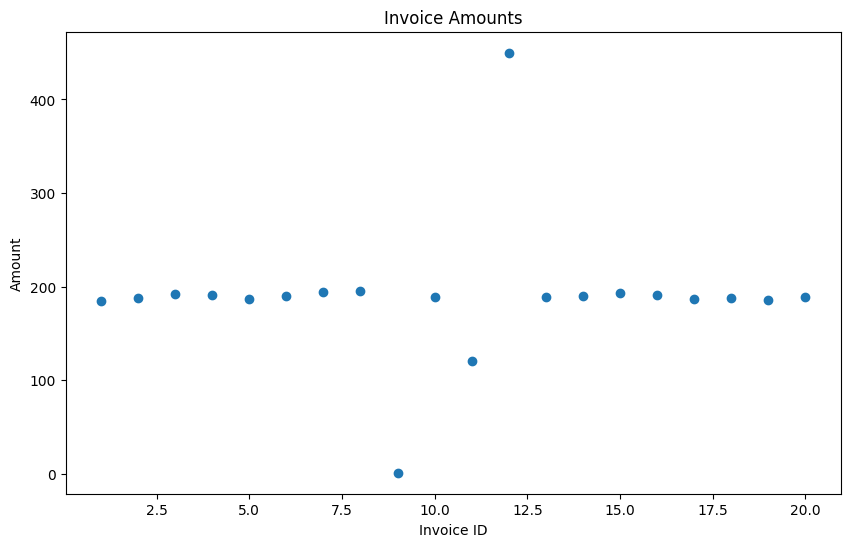

In [3]:
# Create a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(df['Invoice ID'], df['Amount'])
plt.title('Invoice Amounts')
plt.xlabel('Invoice ID')
plt.ylabel('Amount')
plt.show()


## 3. Identify Outliers Using Z-Score Method

We will calculate the mean and standard deviation of the 'Amount' column, compute Z-scores, and flag data points as outliers based on a threshold.
A z-score threshold is a value used to identify outliers in a dataset. Common thresholds are typically around ±2 or ±3 standard deviations from the mean. 
Values beyond these thresholds are considered unusual or potentially outliers. 

### What is the Z-Score Method?
The Z-Score method is a statistical technique used to identify outliers in a dataset. It measures how many standard deviations a data point is from the mean. The Z-Score for a value $\ x $ is calculated as:
$$
Z = \frac{x - \mu}{\sigma}
$$
where:
- $\ x $ is the data point,
- $\ \mu $ is the mean of the dataset,
- $\ \sigma $ is the standard deviation.

**When to use:**
- The Z-Score method is best for data that is approximately normally distributed.
- Common thresholds are ±2 or ±3; points beyond these are considered outliers.

Let's apply the Z-Score method to our data.

In [4]:
# Calculate the mean and standard deviation
mean = np.mean(df['Amount'])
std_dev = np.std(df['Amount'])

# Calculate the Z-score for each data point
df['Z-Score'] = (df['Amount'] - mean) / std_dev

# Define a threshold for identifying outliers
threshold = 2

# Identify outliers
df['Z-Score Outlier'] = np.abs(df['Z-Score']) > threshold

# Display the results
df[['Invoice ID', 'Amount', 'Z-Score', 'Z-Score Outlier']]

Invoice ID  Amount   Z-Score  Z-Score Outlier
0            1     185 -0.064536            False
1            2     188 -0.023776            False
2            3     192  0.030570            False
3            4     191  0.016983            False
4            5     187 -0.037363            False
5            6     190  0.003397            False
6            7     194  0.057743            False
7            8     195  0.071329            False
8            9       1 -2.564461             True
9           10     189 -0.010190            False
10          11     120 -0.947662            False
11          12     450  3.535899             True
12          13     189 -0.010190            False
13          14     190  0.003397            False
14          15     193  0.044156            False
15          16     191  0.016983            False
16          17     187 -0.037363            False
17          18     188 -0.023776            False
18          19     186 -0.050950            False
19          20     189 -0.010190            False

#### Interpreting Z-Score Results
- Data points with a Z-Score greater than the threshold (e.g., |Z| > 2) are considered outliers.
- In the table above, the 'Z-Score Outlier' column marks these points as True.
- Outliers may indicate errors, rare events, or interesting anomalies depending on the context.

Let's visualize these outliers for better understanding.

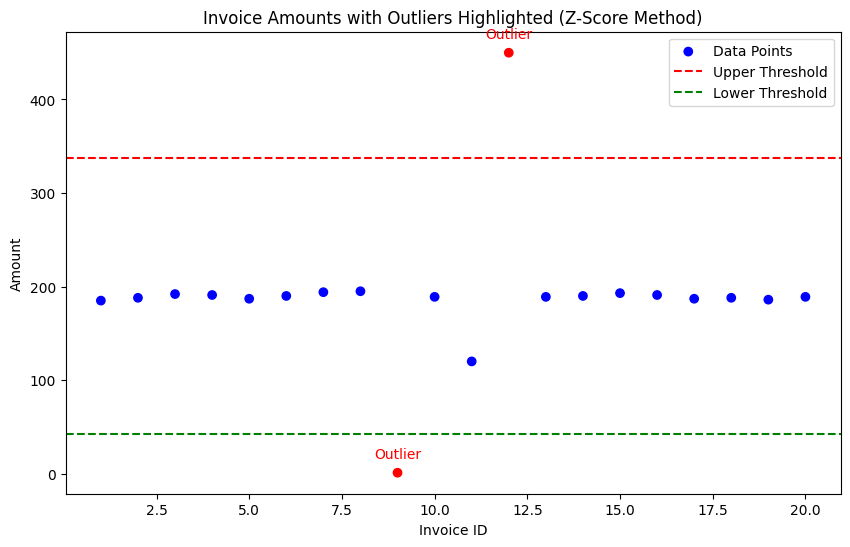

In [5]:
# Create a scatter plot, highlighting outliers
plt.figure(figsize=(10, 6))
# Color points: red for outliers, blue for normal
colors = df['Z-Score Outlier'].map({True: 'red', False: 'blue'})
plt.scatter(df['Invoice ID'], df['Amount'], c=colors, label='Data Points')
plt.title('Invoice Amounts with Outliers Highlighted (Z-Score Method)')
plt.xlabel('Invoice ID')
plt.ylabel('Amount')
plt.axhline(y=mean + threshold * std_dev, color='r', linestyle='--', label='Upper Threshold')
plt.axhline(y=mean - threshold * std_dev, color='g', linestyle='--', label='Lower Threshold')
plt.legend(['Data Points', 'Upper Threshold', 'Lower Threshold'])
# Add annotation for outliers
for i, row in df[df['Z-Score Outlier']].iterrows():
    plt.annotate('Outlier', (row['Invoice ID'], row['Amount']), textcoords="offset points", xytext=(0,10), ha='center', color='red')
plt.show()

## 4. Identify Outliers Using IQR Method

We will compute the first and third quartiles (Q1, Q3), calculate the interquartile range (IQR), and identify outliers outside the lower and upper bounds.

### What is the IQR Method?
The Interquartile Range (IQR) method is a robust technique for detecting outliers based on the spread of the middle 50% of the data.

- **Q1 (25th percentile):** The value below which 25% of the data fall.
- **Q3 (75th percentile):** The value below which 75% of the data fall.
- **IQR:** The difference between Q3 and Q1: $$ IQR = Q3 - Q1 $$
- **Outlier bounds:**
    - Lower bound: $$ Q1 - 1.5 \times IQR $$
    - Upper bound: $$ Q3 + 1.5 \times IQR $$
- Data points outside these bounds are considered outliers.

**When to use:**
- The IQR method is effective for skewed or non-normal data and is less sensitive to extreme values than the Z-Score method.

Let's apply the IQR method to our data.

In [6]:
# Calculate Q1 (25th percentile) and Q3 (75th percentile)
Q1 = df['Amount'].quantile(0.25)
Q3 = df['Amount'].quantile(0.75)

# Calculate the IQR
IQR = Q3 - Q1

# Define the lower and upper bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identify outliers
df['IQR Outlier'] = (df['Amount'] < lower_bound) | (df['Amount'] > upper_bound)

# Display the results
df[['Invoice ID', 'Amount', 'IQR Outlier']]

Invoice ID  Amount  IQR Outlier
0            1     185        False
1            2     188        False
2            3     192        False
3            4     191        False
4            5     187        False
5            6     190        False
6            7     194        False
7            8     195        False
8            9       1         True
9           10     189        False
10          11     120         True
11          12     450         True
12          13     189        False
13          14     190        False
14          15     193        False
15          16     191        False
16          17     187        False
17          18     188        False
18          19     186        False
19          20     189        False

#### Interpreting IQR Results
- Data points outside the lower and upper bounds are flagged as outliers in the 'IQR Outlier' column.
- These outliers may represent rare events, errors, or interesting anomalies.

Let's visualize the IQR outliers for better understanding.

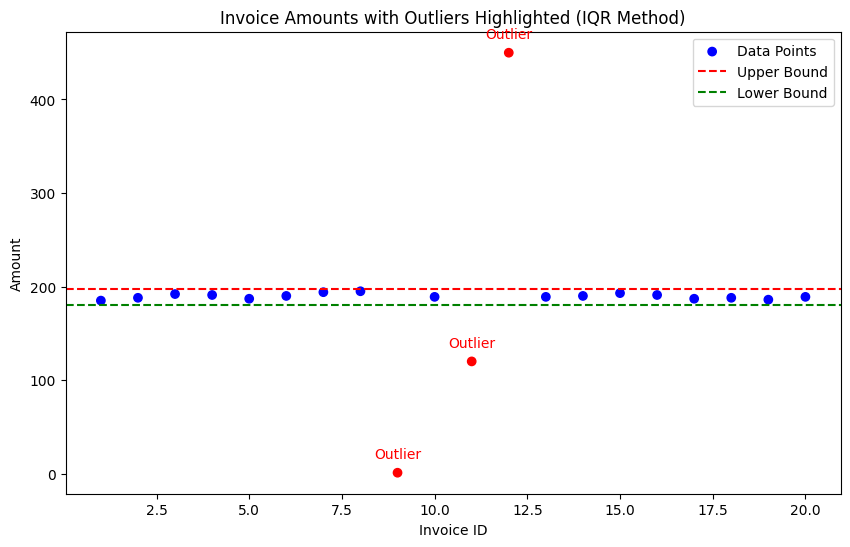

In [7]:
# Create a scatter plot, highlighting outliers by IQR method
plt.figure(figsize=(10, 6))
# Color points: red for outliers, blue for normal
colors = df['IQR Outlier'].map({True: 'red', False: 'blue'})
plt.scatter(df['Invoice ID'], df['Amount'], c=colors, label='Data Points')
plt.title('Invoice Amounts with Outliers Highlighted (IQR Method)')
plt.xlabel('Invoice ID')
plt.ylabel('Amount')
plt.axhline(y=upper_bound, color='r', linestyle='--', label='Upper Bound')
plt.axhline(y=lower_bound, color='g', linestyle='--', label='Lower Bound')
plt.legend(['Data Points', 'Upper Bound', 'Lower Bound'])
# Add annotation for outliers
for i, row in df[df['IQR Outlier']].iterrows():
    plt.annotate('Outlier', (row['Invoice ID'], row['Amount']), textcoords="offset points", xytext=(0,10), ha='center', color='red')
plt.show()

## 5. Identify Outliers Using DBSCAN

We will apply the DBSCAN clustering algorithm to the 'Amount' data and label points as outliers based on the clustering results (DBSCAN labels outliers as -1).

### What is the DBSCAN Method?
DBSCAN (Density-Based Spatial Clustering of Applications with Noise) is a clustering algorithm that groups together points that are closely packed and labels points that lie alone in low-density regions as outliers (noise).
- **Key parameters:**
    - `eps`: Maximum distance between two samples for them to be considered as in the same neighborhood.
    - `min_samples`: Minimum number of samples in a neighborhood for a point to be considered a core point.
- **How it works:**
    - Points in dense regions form clusters.
    - Points that do not belong to any cluster (labeled as -1) are considered outliers.

**When to use:**
- DBSCAN is useful for detecting outliers in data with clusters of similar density and does not require the data to be normally distributed.
- It can find arbitrarily shaped clusters and is robust to noise.

Let's apply DBSCAN to our data.

In [8]:
# Reshape the 'Amount' column to be a 2D array
X = df['Amount'].values.reshape(-1, 1)

# Apply DBSCAN
dbscan = DBSCAN(eps=10, min_samples=3)
dbscan.fit(X)

# Add the DBSCAN labels to the DataFrame
df['DBSCAN_Label'] = dbscan.labels_

# Identify outliers (DBSCAN labels outliers as -1)
df['DBSCAN Outlier'] = df['DBSCAN_Label'] == -1

# Display the results
df[['Invoice ID', 'Amount', 'DBSCAN_Label', 'DBSCAN Outlier']]

Invoice ID  Amount  DBSCAN_Label  DBSCAN Outlier
0            1     185             0           False
1            2     188             0           False
2            3     192             0           False
3            4     191             0           False
4            5     187             0           False
5            6     190             0           False
6            7     194             0           False
7            8     195             0           False
8            9       1            -1            True
9           10     189             0           False
10          11     120            -1            True
11          12     450            -1            True
12          13     189             0           False
13          14     190             0           False
14          15     193             0           False
15          16     191             0           False
16          17     187             0           False
17          18     188             0           False
18          19     186             0           False
19          20     189             0           False

#### Interpreting DBSCAN Results
- Points labeled as -1 by DBSCAN are considered outliers (noise).
- The 'DBSCAN Outlier' column in the table above marks these points as True.
- DBSCAN is especially useful when the data contains clusters and noise, and does not assume any distribution.

Let's visualize the DBSCAN outliers for better understanding.

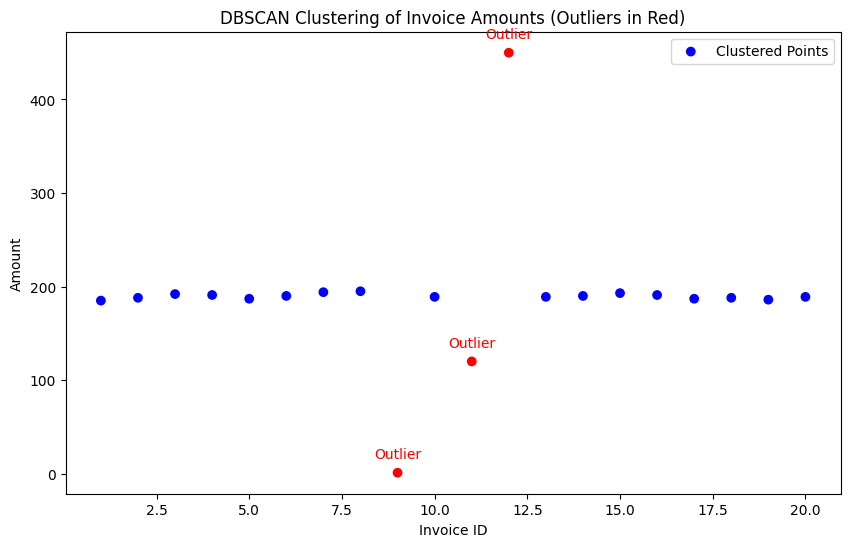

In [9]:
# Create a scatter plot to visualize the outliers identified by DBSCAN.
plt.figure(figsize=(10, 6))
# Assign colors: outliers (-1) in red, clusters in blue/other colors
colors = df['DBSCAN_Label'].map(lambda x: 'red' if x == -1 else 'blue')
plt.scatter(df['Invoice ID'], df['Amount'], c=colors, label='Clustered Points')
plt.title('DBSCAN Clustering of Invoice Amounts (Outliers in Red)')
plt.xlabel('Invoice ID')
plt.ylabel('Amount')
# Annotate outliers
for i, row in df[df['DBSCAN Outlier']].iterrows():
    plt.annotate('Outlier', (row['Invoice ID'], row['Amount']), textcoords="offset points", xytext=(0,10), ha='center', color='red')
plt.legend(['Clustered Points'])
plt.show()

## 8. Comparing Outlier Detection Methods
- **Z-Score:** Best for normally distributed data; sensitive to extreme values.
- **IQR:** Robust to skewed data and outliers; does not assume any distribution.
- **DBSCAN:** Useful for clustered data and can detect noise/outliers without distribution assumptions.

**Choosing a method:**
- Use Z-Score for symmetric, bell-shaped data.
- Use IQR for skewed or non-normal data.
- Use DBSCAN when data may have clusters or you want to detect noise points.

Always visualize and interpret outliers in the context of your domain before making decisions!